In [9]:
from gcsa.event import Event
from gcsa.google_calendar import GoogleCalendar
from gcsa.recurrence import Recurrence, DAILY, SU, SA

import plotly.express as px
import plotly.graph_objects as go

import pandas as pd

from datetime import datetime, timedelta, date
import dateutil
from dateutil.parser import parse
from calendar import monthrange, month_name, day_name
import numpy as np

In [2]:
gcal = GoogleCalendar('keithwdavis@gmail.com',
                          credentials_path='/Users/kdavis10/.credentials/client_secret_3681359253-cj6ds937cv5p30vn8tbms112bjplms95.apps.googleusercontent.com.json')


In [3]:
YR = 2024
class YearData:

    @property
    def year(self):
        return self._year

    @year.setter
    def year(self, year):
        try:
            if self.date.year != year:
                self._year = year
            del self.date
        except (AttributeError, TypeError):
            pass
        
        self._year = year

    @property
    def date(self):
        if self._date is None:
            return datetime.date(self.year, 1, 1)
        return self._date

    @date.setter
    def date(self, date):
        if date.year != self.year:
            raise ValueError(f"Cannot set a date with year outside of instance year.")
        self._date = date
            
    @date.deleter
    def date(self):
        self._date = None

    def __init__(self, year=None, date=None):
        if year is None:
            year = datetime.now().year
        self.year = year

        if date is None:
            date = datetime(self.year, 1, 1)
        self.date = date


    def first_day(self):
        return datetime(self._year, 1, 1)

    def last_day(self):
        return datetime(self.year, 12, 31)
        
    def length(self):
        return self.last_day() - self.first_day() + timedelta(1)
    
    def weekday(self, n=None):
        if n is None:
            return self.date.weekday()
        else:
            return self.weekday_from_int(n)

    def get_year(self):
        return self.year()

    def date_from_int(self, n):
        return self.first_day() + timedelta(n)

    def weekday_from_int(self, n):
        return self.date_from_int(n).weekday()

    def monthrange(self, month=None):
        if month is None:
            month = self.date.month
        return monthrange(self.year, month)

    def iterdates(self, start=0, end=None):

        if end is None:
            end = self.last_day()
        
        day = timedelta(1)
        # If start is an int, create a date from it.
        try:
            start = self.date_from_int(start)
        except TypeError as e:
            # If not an int, it may be datetime.
            pass
        try:
            if not (self.first_day() <= start <= self.last_day()):
                raise ValueError(f"start must be in {self._year}")
        except TypeError as e:
            raise TypeError("start must be an integer or datetime.") from e
        while self.first_day() <= start <= self.last_day():
            yield start
            start += day

    def to_dict(self):
        columns = ["date", "year", "month", "month_str", "day", "weekday", "weekday_str"]
        funcs = [lambda d: d,
                 lambda d: d.year,
                 lambda d: d.month,
                 lambda d: month_name[d.month],
                 lambda d: d.day,
                 lambda d: d.weekday(),
                 lambda d: day_name[d.weekday()]]
        col_func = dict(zip(columns, funcs))
            
        year_dict = {}
        for column in columns:
            year_dict[column] = []
            
        for date in self.iterdates():
            for column in col_func:
                year_dict[column].append(col_func[column](date))

        return year_dict

    def to_DataFrame(self):
        return pd.DataFrame(self.to_dict())
            
        
        
        
        
        

In [4]:
y = YearData(2024)
ydict = y.to_dict()

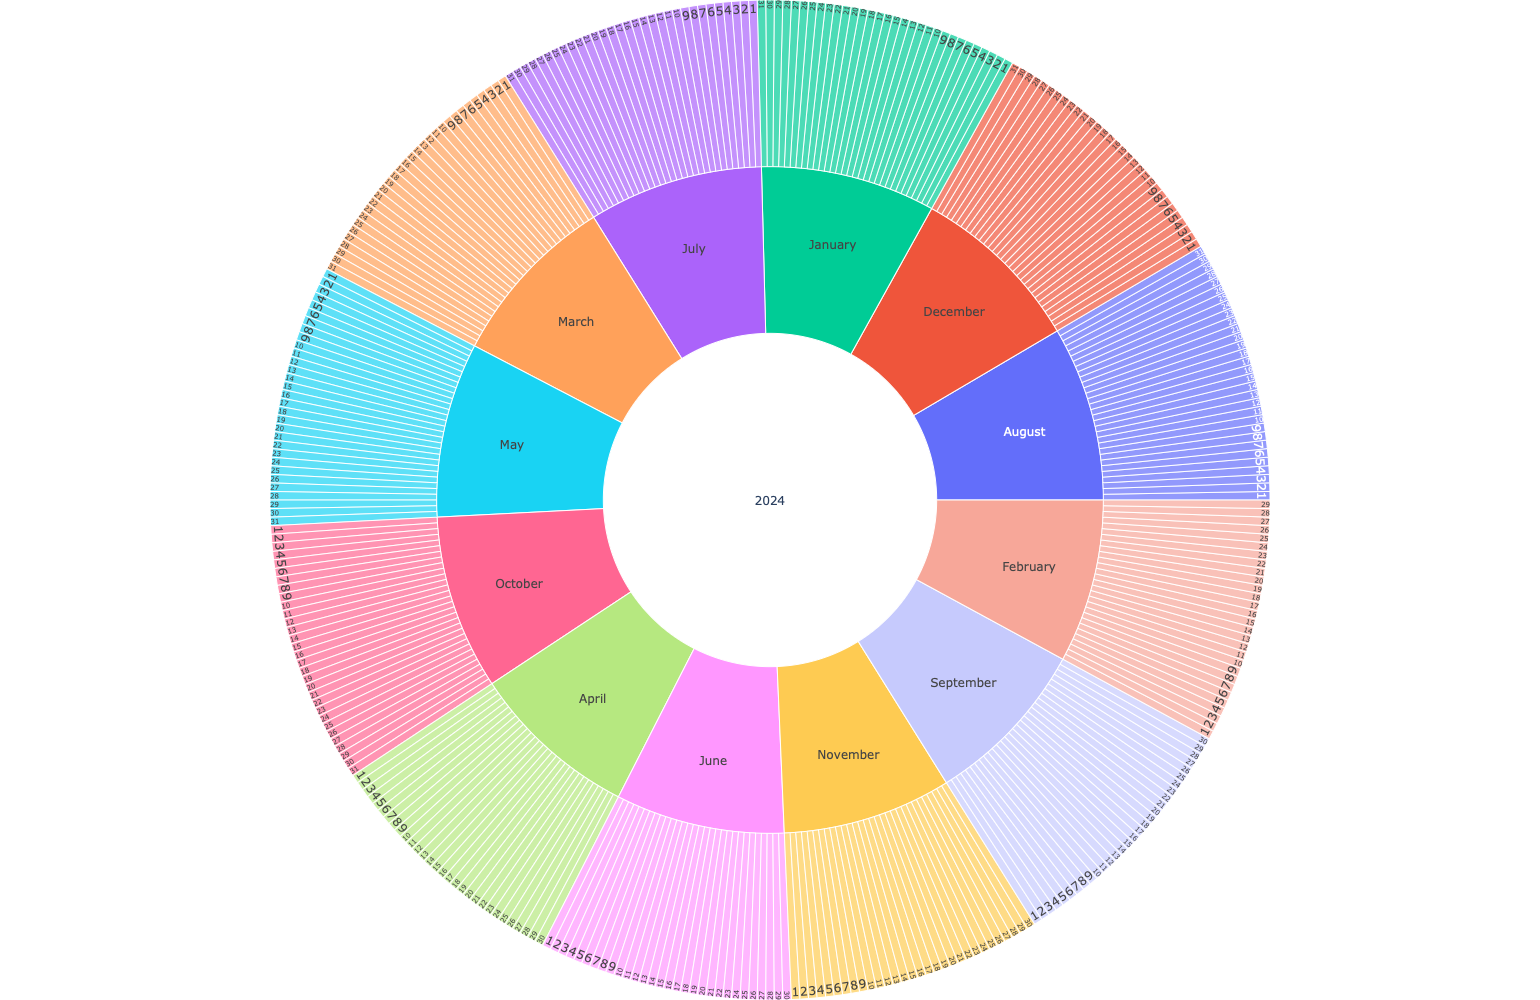

In [5]:
y =YearData(2024)
df = y.to_DataFrame()
ydict = y.to_dict()
#df.set_index("date")

fig = px.sunburst(df, path=["year", "month_str", "day"], values=[1] * y.length().days)
# Update layout for tight margin
# See https://plotly.com/python/creating-and-updating-figures/
fig.update_layout(margin = dict(t=0, l=0, r=0, b=0), height=1000)

#ids = [y.year] + [str(m) for m in month_name]
#parents = [""] + ["2024"] * 12
#fig = go.Figure()
#sb = go.Sunburst(ids=ids, parents=parents, sort=False)
#fig.add_trace(sb)
#fig.update_layout(margin = dict(t=0, l=0, r=0, b=0), height=1000)
fig.show()

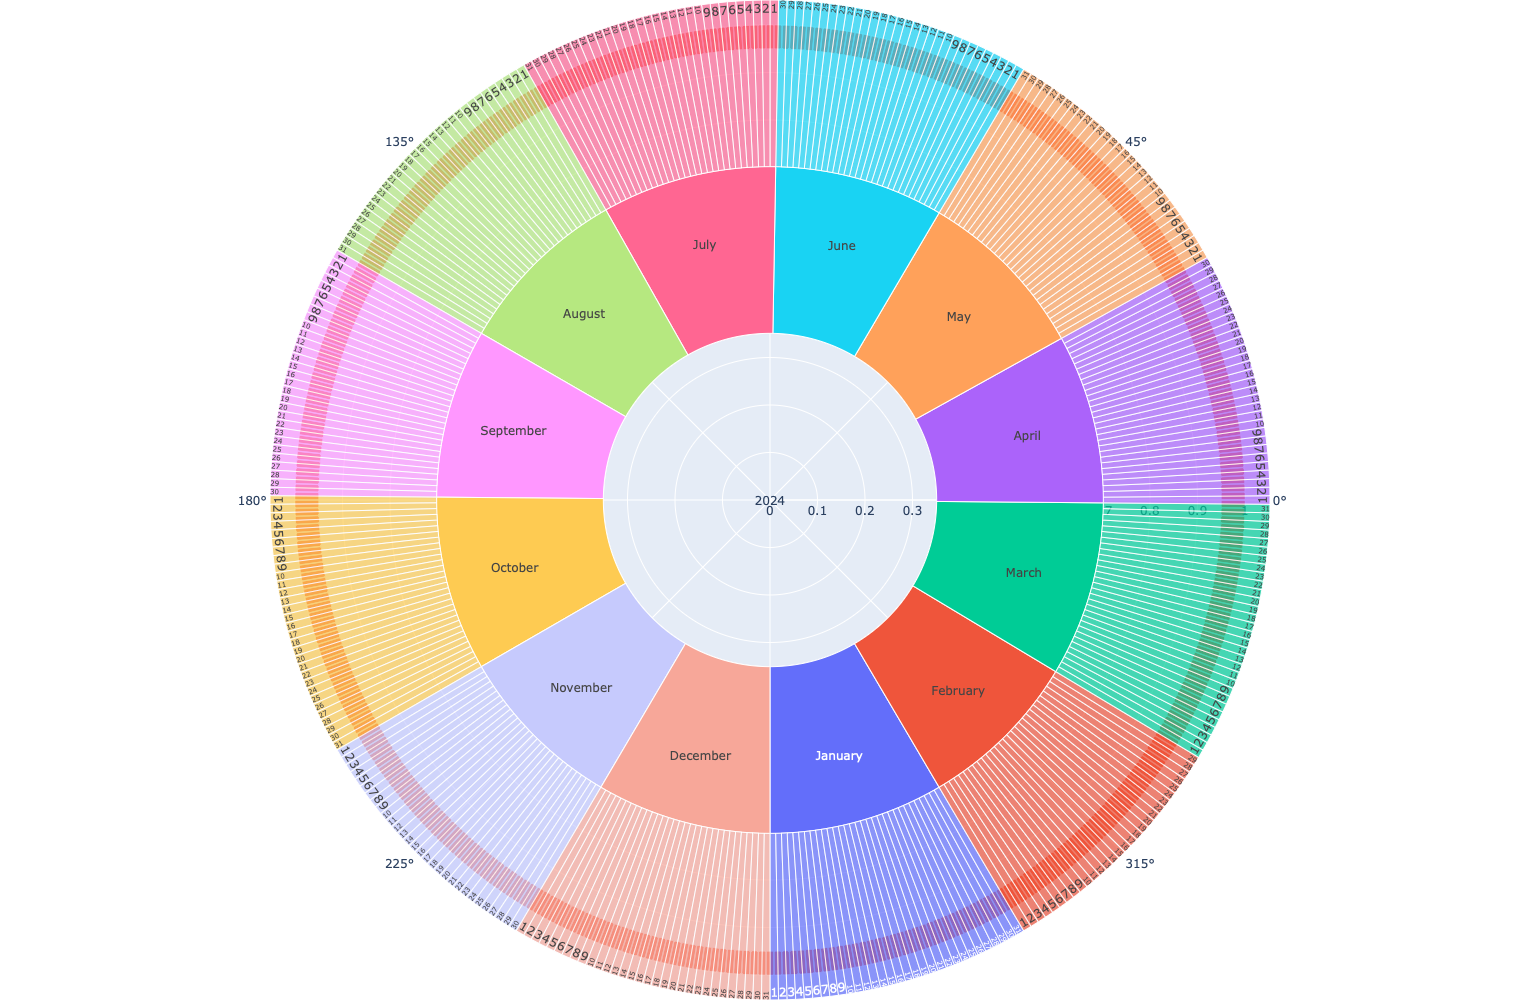

In [11]:
fig2 = go.Figure()

ids = ["2024"] + [str(m) for m in month_name][1:] + [str(d.date()) for d in ydict["date"]]
parents = [""] + 12 * [2024] + ydict["month_str"]
values = [0] + 12 * [0] + len(ydict["day"]) * [1]
labels = ["2024"] + [str(m) for m in month_name][1:] + [str(d) for d in ydict["day"]]

sb2 = go.Sunburst(labels=labels, ids=ids, parents=parents,values=values, sort=False, rotation=-90)
dbase=np.array([0.95] * y.length().days)
dr=1 - dbase
fig2.add_trace(sb2)
fig2.add_trace(go.Barpolar(r=dr, base=dbase,
                          theta0 = -90,
                          dtheta = (360 / y.length().days),
                          name="date",
                          hovertext=[d.date() for d in ydict["date"]]))
fig2.update_layout(margin = dict(t=0, l=0, r=0, b=0), height=1000)
fig2.show()

In [55]:
print(ids)

['2024', '', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']


In [56]:
[str(m) for m in month_name]

['',
 'January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December']

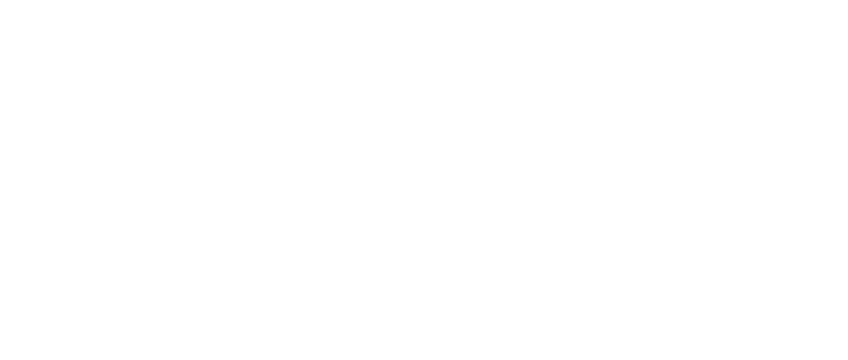

In [80]:
fig3 = go.Figure()

ids = ["2024"] + ydict["month_str"] + [str(d) for d in ydict["date"]]
parents = [""] + 366 * [2024] + ydict["month_str"]
values = [0] + [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31] + [1] * 366

sb3 = go.Sunburst(labels=ids, parents=parents,values=values, sort=False, rotation=-90)
fig3.add_trace(sb3)
fig3.show()

In [84]:
[str(d.date()) for d in ydict["date"]]

['2024-01-01',
 '2024-01-02',
 '2024-01-03',
 '2024-01-04',
 '2024-01-05',
 '2024-01-06',
 '2024-01-07',
 '2024-01-08',
 '2024-01-09',
 '2024-01-10',
 '2024-01-11',
 '2024-01-12',
 '2024-01-13',
 '2024-01-14',
 '2024-01-15',
 '2024-01-16',
 '2024-01-17',
 '2024-01-18',
 '2024-01-19',
 '2024-01-20',
 '2024-01-21',
 '2024-01-22',
 '2024-01-23',
 '2024-01-24',
 '2024-01-25',
 '2024-01-26',
 '2024-01-27',
 '2024-01-28',
 '2024-01-29',
 '2024-01-30',
 '2024-01-31',
 '2024-02-01',
 '2024-02-02',
 '2024-02-03',
 '2024-02-04',
 '2024-02-05',
 '2024-02-06',
 '2024-02-07',
 '2024-02-08',
 '2024-02-09',
 '2024-02-10',
 '2024-02-11',
 '2024-02-12',
 '2024-02-13',
 '2024-02-14',
 '2024-02-15',
 '2024-02-16',
 '2024-02-17',
 '2024-02-18',
 '2024-02-19',
 '2024-02-20',
 '2024-02-21',
 '2024-02-22',
 '2024-02-23',
 '2024-02-24',
 '2024-02-25',
 '2024-02-26',
 '2024-02-27',
 '2024-02-28',
 '2024-02-29',
 '2024-03-01',
 '2024-03-02',
 '2024-03-03',
 '2024-03-04',
 '2024-03-05',
 '2024-03-06',
 '2024-03-